In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
import numpy as np
import ase 
from ase.units import Bohr 
import torch
import metatensor
from metatensor import TensorMap, TensorBlock, Labels
import matplotlib.pyplot as plt
from ase.io import read 
from pyscf.pbc.tools import pyscf_ase 
import hickle
from mlelec.utils.metatensor_utils import labels_where

In [197]:
frames = read('C2_rotated.xyz', ':')
# frames = read('examples/data/periodic/c2/C2_174.extxyz', ':10')
for f in frames:
    f.pbc = [True, True, True]

kmesh = [4, 4, 1]
filename = "C2_rotated"
# filename = "C2_174"
translated_matrices = hickle.load('examples/data/periodic/c2/results_{}/fock_Ls.hkl'.format(filename))
weights = hickle.load('examples/data/periodic/c2/results_{}/weights.hkl'.format(filename))
kpts = hickle.load('examples/data/periodic/c2/results_{}/kpts.hkl'.format(filename))  
expkL = hickle.load('examples/data/periodic/c2/results_{}/expkL.hkl'.format(filename))
Ls = np.asarray([list(k) for k in translated_matrices.keys()])

In [198]:
## Fix orbital order 
from mlelec.utils.twocenter_utils import fix_orbital_order
orbs = {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}
for T in translated_matrices.keys():
    translated_matrices[T] = fix_orbital_order(translated_matrices[T], frames, orbs)


In [199]:
positive_Ls = []
for L in Ls:
    lL  = list(L)
    lmL = list(-L)
    if not (lL in positive_Ls):
        if not (lmL in positive_Ls):
            positive_Ls.append(lmL)
print(len(positive_Ls), len(Ls)   )

25 49


In [200]:
def wrap_translation(i,Nk):
    r = i
    if abs(i)>Nk/2:
        r=i-np.sign(i)*np.floor(abs(i)/(Nk/2))*Nk
    # NOT adding the following condition to maintain -T for each T
    # elif abs(i) == Nk/2:
    #     r = abs(i)
        
    # Implements the following:
    # if i >= Nk/2:
    #    r=i-np.floor(i/(Nk/2))*Nk
    # elif i < -Nk/2:
    #    r=i+np.floor(-i/(Nk/2))*Nk
    if abs(i)>= Nk:
        return wrap_translation(np.sign(i)*(abs(i)-Nk),Nk)
    return int(r)
def mic_translation(T:list[int,int,int],kmesh):
    n = []
    for i in range(3):
        n.append(int(wrap_translation(T[i],kmesh[i])))
    return n


In [201]:
from collections import defaultdict
kmesh = [4, 4, 1]
unique_Ls = defaultdict(list)
unique_matrices = defaultdict(list)
for t in translated_matrices.keys():
    s = mic_translation(t, kmesh) 
    if tuple(s) not in translated_matrices:
        raise ValueError("wrapped key not found")
    n = translated_matrices[t] - translated_matrices[tuple(s)]
    
    unique_Ls[tuple(s)].append(t)
    
    # print(t,s)
    
    if np.linalg.norm(n) > 1e-8:
        print(t, s, n)
        # print(translated_matrices[t], translated_matrices[tuple(s)])
        print(np.linalg.norm(n))
        raise ValueError("HORROR - MIC translations not working")

for s in unique_Ls.keys():
    unique_matrices[s] = translated_matrices[s]
    for t in unique_Ls[s]:
        norm = np.linalg.norm(translated_matrices[t] - unique_matrices[s])
        if norm > 1e-8:
            print(t, s, norm)
            raise ValueError("Uh oh - mapped MIC translations dont have the same matrix")
        
for t in unique_Ls:
    assert tuple([-t[0], -t[1], -t[2]]) in unique_Ls, ("Missing negative translation", t)


In [202]:
# select a subset of positive translations
desired_shifts = [
    [0, 0, 0],
 [1, 0, 0],
 [0,1,0], 
 [1, 1, 0],
 [1,-1,0],
 [2,0,0], 
[0,2,0], 
[2,1,0],
 ]

# desired_shifts = Ls 

withnegative_shifts = desired_shifts.copy()
for s in withnegative_shifts[:]:
    withnegative_shifts.append([-s[0], -s[1], -s[2]])

selected_matrices = {}
for s in withnegative_shifts:
    selected_matrices[tuple(s)] = translated_matrices[tuple(s)]


## Matrix to blocks 

In [203]:
from mlelec.utils.twocenter_utils import _to_blocks, _to_matrix, _to_coupled_basis, _to_uncoupled_basis, discard_nonhermiticity

In [205]:
matrices = {}
for s in withnegative_shifts[:]:
    matrices[tuple(s)] = unique_matrices[tuple(s)]

In [206]:
target_blocks = {}
target_blocks = {}
target_coupled_blocks = {}
for s in withnegative_shifts[:]:
    target_blocks[tuple(s)] = _to_blocks(matrices[tuple(s)], frames=frames, orbitals=orbs, NH=True) # matrix -> uncoupled
    target_coupled_blocks[tuple(s)] = _to_coupled_basis(target_blocks[tuple(s)], orbs, skip_symmetry=True) # uncouple -> coupled


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/twocenter_utils.py:162: UserWarning: Matrix is neither hermitian nor antihermitian - attempting to use _toblocks for NH
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:129: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  block = TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:91: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  return TensorMap(keys, blocks)


In [207]:
from collections import defaultdict
blocks = []
tmap_keys = []
for translation in target_coupled_blocks.keys():
    for i, (key, block) in enumerate(target_coupled_blocks[translation].items()):
        blocks.append(block.copy())
        x = list(key)
        x.extend(translation)
        tmap_keys.append(x)
keys = Labels(next(iter(target_coupled_blocks.values())).keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray(tmap_keys))
target = TensorMap(keys=keys, blocks=blocks)

target = target.keys_to_samples('cell_shift_a')
target = target.keys_to_samples('cell_shift_b')
target = target.keys_to_samples('cell_shift_c')


/tmp/ipykernel_92716/3725357898.py:11: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  target = TensorMap(keys=keys, blocks=blocks)


In [220]:
Nk = len(kpts)
nao = 10
small_shifts_target = []
for ifr, frame in enumerate(frames): 
    kmatrix = torch.zeros((Nk, nao, nao)).type(torch.complex128)

    # shift_indices = [np.where(np.all(Ls==np.asarray(s), axis=1))[0][0] for s in withnegative_shifts]
    for key in withnegative_shifts:
        key = tuple(key)
        for kpt in range(Nk):
            kmatrix[kpt] += translated_matrices[key][ifr] * weights[key] * expkL[key][kpt]
    kmatrix = kmatrix / Nk
    small_shifts_target.append(kmatrix) 
small_shifts_target = torch.stack(small_shifts_target).swapaxes(0,1)

## feature

In [222]:
from rascaline import SphericalExpansionByPair as PairExpansion
from rascaline import SphericalExpansion
from mlelec.utils.metatensor_utils import labels_where
from metatensor import Labels
from mlelec.features.acdc import twocenter_hermitian_features, single_center_features, pair_features, twocenter_hermitian_features_periodic
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys

In [223]:
#TODO: generate feats only for relevant shifts (keyword) . use diff cutoff for rhoij, gij

In [224]:
hyper = {'cutoff': 6,
          'max_radial':8, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
#test_rcut_shift: 
def test_rcut(frame, hypers, shifts):
    hypers_ij = hypers.copy()
    r = hypers['cutoff']
    cell = frame.cell.copy()
    norms = np.linalg.norm(frame.cell, axis=1)
    assert isinstance(shifts[0], tuple)
    max_shift = tuple([np.max(shifts, axis=(0,1))]*3)
    max_disp = np.sqrt(np.dot(max_shift, norms**2))+ frame.get_all_distances().max()**2
    if r < max_disp:
        hypers_ij['cutoff'] = max_disp    
    
    return hypers_ij

# hypers = test_rcut(frames[100], hyper, [(1,1,1)])
hypers = hyper
gij = PairExpansion(**hypers)
pair = gij.compute(frames)


In [225]:
# from mlelec.utils.symmetry import ClebschGordanReal
# from mlelec.features.acdc_utils import fix_gij, acdc_standardize_keys, cg_combine, cg_increment, relabel_keys
# L = max(2, hypers["max_angular"])
# # cg = ClebschGordanReal(lmax=L)
# rho0_ij = pair
# rho0_ij = fix_gij(rho0_ij)
# rho0_ij = acdc_standardize_keys(rho0_ij)

In [231]:
rhoij = pair_features(frames, hypers, order_nu=1,  all_pairs=True, lcut=2, max_shift=[2,3,1], both_centers=True)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:127: UserWarning: Using cutoff 7.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:171: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


In [232]:
rhonu_i = single_center_features(
            frames, order_nu=2, hypers=hypers, lcut=2
        ) 
pair_zero_shift = pair_features(frames, hypers, order_nu=1,  all_pairs=True, lcut=2, max_shift=[1,1,1], feature_names = rhonu_i.property_names)

pair_feat = pair_zero_shift
blocks = []
for i, (key, block) in enumerate(pair_feat.items()):
    samples_lab, idx = labels_where(block.samples, selection=Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray([[0,0,0]]).reshape(-1, 3)), return_idx=True)
    samples_lab =  Labels(samples_lab.names[:3], values=samples_lab.values[:,:3])
    tb = TensorBlock(
        samples=samples_lab,
        values=block.values[idx],
        properties=block.properties,
        components = block.components
    )
    blocks.append(tb)
pair_zero_shift = TensorMap(keys = pair_feat.keys, blocks=blocks)

hfeat0 = twocenter_hermitian_features_periodic(rhonu_i , pair_zero_shift, shift=[0,0,0])

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:127: UserWarning: Using cutoff 2.0 for all pairs feature
  warnings.warn(
/tmp/ipykernel_92716/516060003.py:11: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  tb = TensorBlock(
/tmp/ipykernel_92716/516060003.py:18: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  pair_zero_shift = TensorMap(keys = pair_feat.keys, blocks=blocks)
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:238: DeviceWarning: Values and labels for this block are on differen

In [233]:
from mlelec.features.acdc import twocenter_features_periodic_NH
hfeat = twocenter_features_periodic_NH(single_center=None, pair= rhoij)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:335: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:389: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:400: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels t

In [234]:
withnegative_shifts = withnegative_shifts[1:] # remve zero shift

## train

In [236]:
from mlelec.models.linear import MLP
from mlelec.data.dataset import MLDataset, MoleculeDataset 

In [237]:
def translations_to_keys(target:TensorMap, cell_shifts):
    recon_blocks = {}
    
    for translation in cell_shifts:
        blocks = []
        for key, block in target.items():
            _,i = labels_where(block.samples, Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values = np.asarray([translation[0], translation[1], translation[2]]).reshape(1,-1)), return_idx=True)
            blocks.append(TensorBlock(samples = Labels(target.sample_names[:-3], values=np.asarray(block.samples.values[i])[:,:-3]),values=block.values[i],
                                        components=block.components,
                                        properties=block.properties))
        tmap = TensorMap(target.keys, blocks)
        recon_blocks[tuple(translation)] = tmap
    return recon_blocks

In [238]:
target0 = translations_to_keys(target, [[1,0,0]])[(1,0,0)]
# target0

/tmp/ipykernel_92716/966334412.py:8: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  blocks.append(TensorBlock(samples = Labels(target.sample_names[:-3], values=np.asarray(block.samples.values[i])[:,:-3]),values=block.values[i],
/tmp/ipykernel_92716/966334412.py:11: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  tmap = TensorMap(target.keys, blocks)


In [270]:
hfeat # features corresponding to the zero shift should not be 

TensorMap with 18 blocks
keys: order_nu  inversion_sigma  spherical_harmonics_l  species_center  species_neighbor  block_type
         3             1                   0                  6                6              0
         3             1                   1                  6                6              0
                                                   ...
         3            -1                   0                  6                6              1
         3            -1                   0                  6                6              -1

## train zeroshift 

In [239]:
import torch.nn as nn
class LinearModelPeriodic(nn.Module):
    def __init__(self, twocfeat, target_blocks, frames, orbitals, device=None, cell_shifts=None, **kwargs):
        super().__init__()
        self.feats = twocfeat
        self.target_blocks = target_blocks
        self.target_blocks = target_blocks
        self.frames = frames
        self.orbitals = orbitals
        self.cell_shifts = cell_shifts
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dummy_property = self.target_blocks[0].properties
        self._submodels(**kwargs)
        print(self.cell_shifts, len(self.cell_shifts))
    def _submodels(self, **kwargs):
        self.blockmodels = {}
     
        for k in self.target_blocks.keys:
            blockval = torch.linalg.norm(self.target_blocks[k].values)
            if blockval > 1e-5:
                feat = map_targetkeys_to_featkeys(self.feats, k)
                self.blockmodels[str(tuple(k)+(1,))] = MLP(nin=feat.values.shape[-1], nout=1, nhidden=kwargs.get("nhidden",10), nlayers=kwargs.get("nlayers",2))
        self.model = torch.nn.ModuleDict(self.blockmodels)
        self.model.to(self.device)

    def forward(self):
        self.recon = {}
       
        pred_blocks = []
        
        for k, block in self.target_blocks.items():
            # print(k)
            blockval = torch.linalg.norm(block.values)
            
            if blockval > 1e-5:
                sample_names = block.samples.names
                feat = map_targetkeys_to_featkeys(self.feats, k)
                nsamples,ncomp, nprops = block.values.shape
                #nsamples, ncomp, nprops = feat.values.shape
                _,sidx = labels_where(feat.samples, Labels(sample_names, values = np.asarray(block.samples.values).reshape(-1,len(sample_names))), return_idx=True)
                pred = self.blockmodels[str(tuple(k)+(1,))](feat.values[sidx])
                # print(pred.shape, nsamples)
               
                pred_blocks.append(TensorBlock(values=pred.reshape((nsamples, ncomp, 1)),samples=block.samples,
                                                   components=block.components,
                                                   properties=self.dummy_property))
            else: 
                pred_blocks.append(block.copy())
        pred_tmap = TensorMap(self.target_blocks.keys, pred_blocks)
            
        

        # if len(self.cell_shifts) == 1:
        #     return _to_matrix(_to_uncoupled_basis(pred_tmap), frames = frames, orbitals=orbs)
        # else:
        self.recon_mat = self.translations_to_keys(pred_tmap)
            # _to_matrix(_to_uncoupled_basis(pred_sum_dict[s]), frames = self.frames, orbitals=self.orbitals)

        return self.recon_mat

    def translations_to_keys(self, target:TensorMap):
        recon_blocks = {}
        rmat = {}
        
        for translation in self.cell_shifts:
            blocks = []
            for key, block in target.items():
                _,i = labels_where(block.samples, Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values = np.asarray([translation[0], translation[1], translation[2]]).reshape(1,-1)), return_idx=True)
                blocks.append(TensorBlock(samples = Labels(target.sample_names[:-3], values=np.asarray(block.samples.values[i])[:,:-3]),
                                          values=block.values[i],
                                          components=block.components,
                                          properties=block.properties))
            tmap = TensorMap(target.keys, blocks)
            recon_blocks[tuple(translation)] = tmap
            
        for s in self.cell_shifts[:]:
            rmat[tuple(s)] = _to_matrix(_to_uncoupled_basis(recon_blocks[tuple(s)]), frames = frames, orbitals=orbs)
        
        return rmat
    

             

In [346]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= [[2,1,0]], 
                            nhidden=16, nlayers=2)


[[2, 1, 0]] 1


In [347]:
with torch.no_grad():
    for layer in model.state_dict():
        # print(layer)
        model.state_dict()[layer].data.fill_(1)

In [348]:
init_pred = model.forward()
init_pred[(2,1,0)].shape

/tmp/ipykernel_92716/2151646801.py:45: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  pred_blocks.append(TensorBlock(values=pred.reshape((nsamples, ncomp, 1)),samples=block.samples,
/tmp/ipykernel_92716/2151646801.py:50: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  pred_tmap = TensorMap(self.target_blocks.keys, pred_blocks)
/tmp/ipykernel_92716/2151646801.py:70: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should 

torch.Size([3, 10, 10])

In [351]:
mask = init_pred[(2,1,0)] < 1e-7
init_pred[(2,1,0)][mask] = 0
# init_pred[(1,1,0)]

In [356]:
plt.rcParams['figure.dpi'] = 400
def plot_hamiltonian(matrix, plot_abs = False, write_values = True, plot_structure = False, structure = None):

    if plot_structure:
        fig, (ax, ax_struc) = plt.subplots(ncols = 2, figsize = (plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
    else:
        fig, ax = plt.subplots()

    if plot_abs:
        m = np.abs(matrix)
    else:
        m = matrix
        
    mappable = ax.matshow(m)

    if write_values:
        ind_array = np.arange(m.shape[0])
        x, y = np.meshgrid(ind_array, ind_array)
        for i, j in zip(x.flatten(), y.flatten()):
            c = matrix[j,i]
            if np.abs(c) <= 1e-50:
                c = 0
            ax.text(i, j, '{:.2e}'.format(c), va='center', ha='center', fontsize = 4)
    
    ax.set_xticks(range(m.shape[0]))    
    ax.set_xticklabels(['1s','2s','2px','2py','2pz','1s','2s','2px','2py','2pz'])
    ax.set_yticks(range(m.shape[1]))    
    ax.set_yticklabels(['1s','2s','2px','2py','2pz','1s','2s','2px','2py','2pz'])

    if plot_structure and structure is not None:
        plot_atoms(structure, ax = ax_struc)
        ax_struc.set_axis_off()
    elif plot_structure and structure is None:
        raise ValueError('An ASE structure must be provided when plot_structure == True.')
        
    return fig, ax, mappable



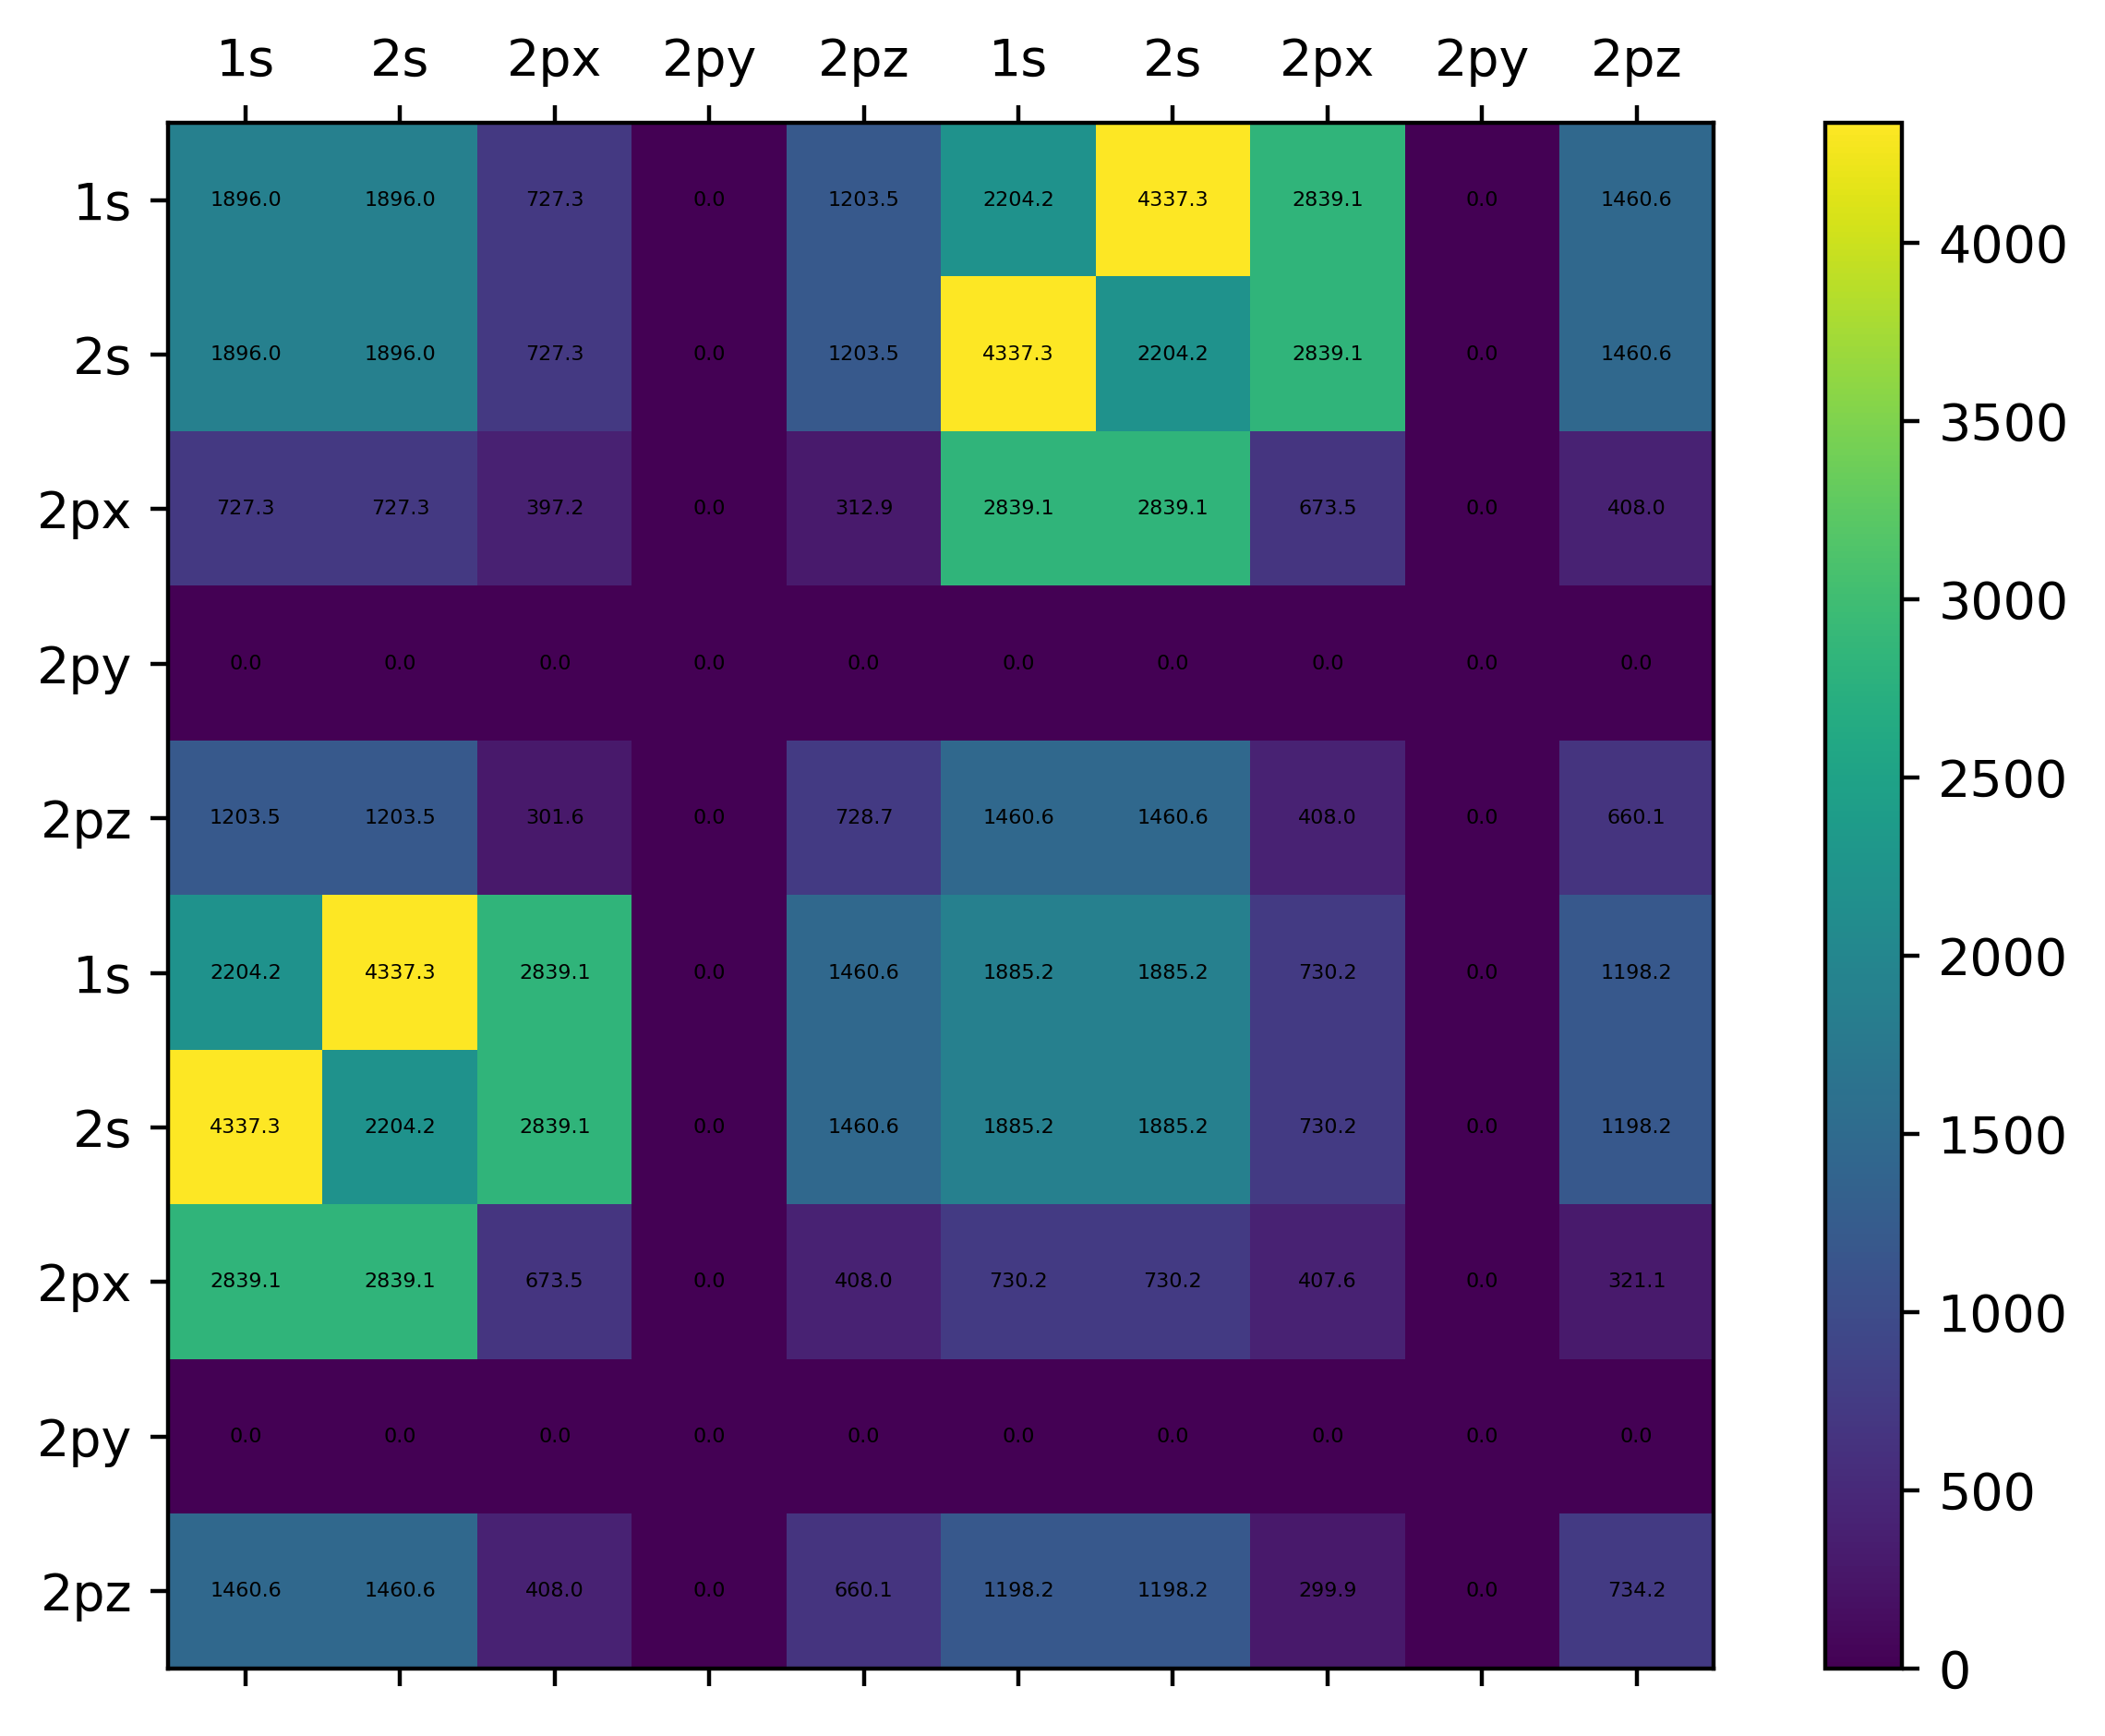

In [354]:
fig, ax, mappable = plot_hamiltonian(init_pred[2,1,0].detach().cpu()[0], plot_abs = True)
fig.colorbar(mappable, ax=ax)
fig.tight_layout()
fig.savefig('/home/nigam/inpred210.png', dpi = 400, bbox_inches = 'tight')

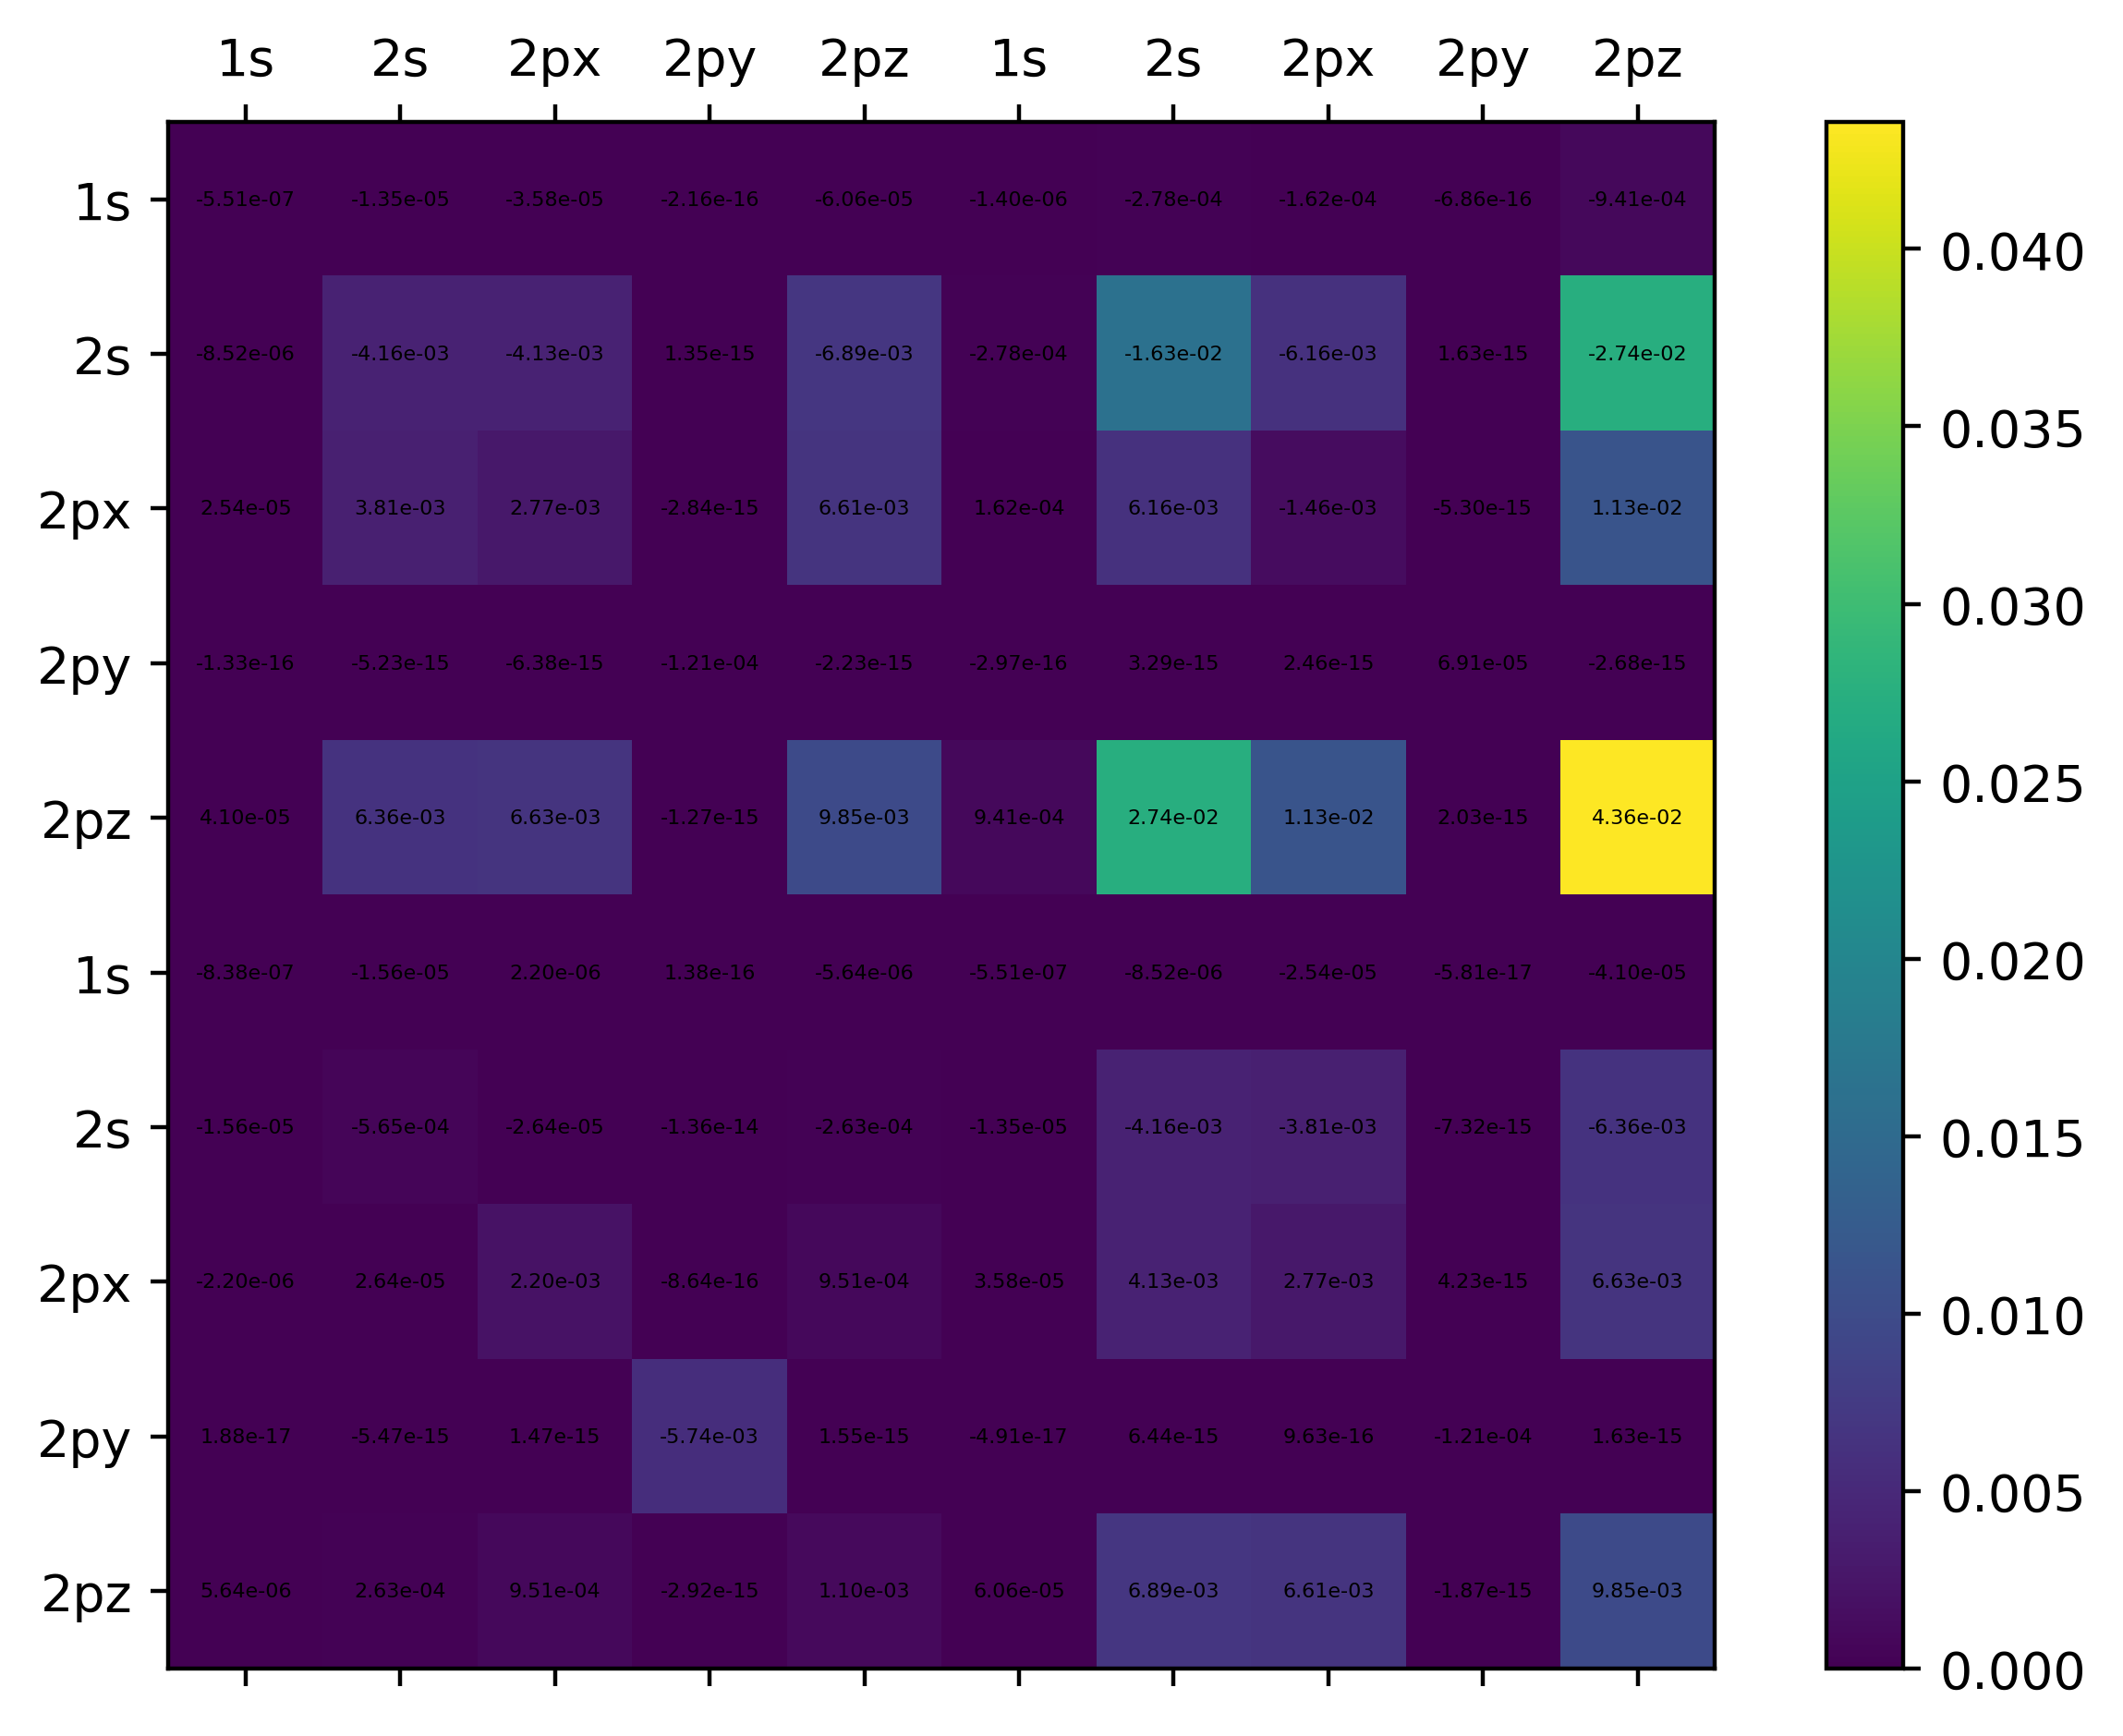

In [357]:
fig, ax, map = plot_hamiltonian(matrices[2,1,0].detach().cpu()[0], plot_abs = True)
plt.colorbar(map, ax=ax)
fig.tight_layout()
fig.savefig('/home/nigam/actual210.png', dpi = 400, bbox_inches = 'tight')

In [254]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)

def closure():
    optimizer.zero_grad()
    rmat = model.forward()
    loss = torch.linalg.norm(rmat - matrices)**2
    loss.backward()
    return loss

losses = []
for i in range(1300):
    # loss = closure()
    # optimizer.step(closure)

    optimizer.zero_grad()
    rmat = model.forward()
    loss = 0
    for s in rmat.keys():            
        loss += torch.linalg.norm(rmat[s]-matrices[tuple(s)])**2
    # loss = torch.linalg.norm(rmat - mat0)**2

    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%1 ==0:
        print(i, loss.item())


/tmp/ipykernel_92716/2151646801.py:45: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  pred_blocks.append(TensorBlock(values=pred.reshape((nsamples, ncomp, 1)),samples=block.samples,
/tmp/ipykernel_92716/2151646801.py:50: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  pred_tmap = TensorMap(self.target_blocks.keys, pred_blocks)
/tmp/ipykernel_92716/2151646801.py:70: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should 

0 15.483041387032241
1 14.758928074969791
2 14.001973568613693
3 13.35677340571285
4 12.788216460681973
5 12.282764100334267
6 11.863142263641064
7 11.546784012915012
8 11.336008242967882
9 11.218127998487505
10 11.169032839838351
11 11.158716663891552
12 11.156668449816644
13 11.139077385743459
14 11.095692795790896
15 11.029148053901789
16 10.94931727711128
17 10.867638596528735
18 10.793219631225842
19 10.731035690925788
20 10.68198951126022
21 10.644100906983217
22 10.613940201522196
23 10.587749663095307
24 10.56212825702669
25 10.534382496705897
26 10.502671758911188
27 10.466051328134585
28 10.424457305819569
29 10.378596947692767
30 10.329729448749756
31 10.279351391950451
32 10.228852732298519
33 10.179245094085598
34 10.131011057652112
35 10.08408138046559
36 10.03792258716489


KeyboardInterrupt: 

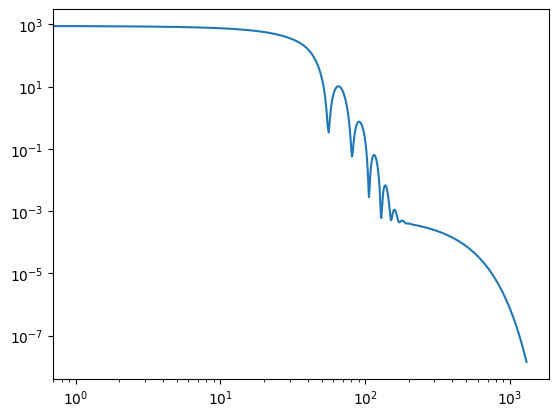

In [ ]:
plt.loglog(losses)